In [3]:
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from statsmodels.stats.proportion import proportion_confint 

In [4]:
df = pd.read_feather("/shared/3/projects/benlitterer/podcastData/processed/mayJune/mayJuneDataRoles.feather")

In [5]:
df["cleanDatesLoc"] = pd.to_datetime(df["cleanDatesLoc"], unit="ms") 

In [6]:
#first get subset after floyd's murder 
afterFloyd = df[df["cleanDatesLoc"] >= "2020-05-25"] 

In [7]:
print(f'number of podcasts after Floyd: {len(afterFloyd["rssUrl"].unique())}')
print(f'number of episodes after Floyd: {len(afterFloyd["potentialOutPath"].unique())}')

number of podcasts after Floyd: 178937
number of episodes after Floyd: 644870


In [8]:
afterFloyd["hasFloyd"] = afterFloyd["transcript"].apply(lambda x: "george floyd" in " ".join(x.split()).lower())

/tmp/ipykernel_3351930/103397015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afterFloyd["hasFloyd"] = afterFloyd["transcript"].apply(lambda x: "george floyd" in " ".join(x.split()).lower())


In [9]:
hasFloyd = afterFloyd[afterFloyd["hasFloyd"] == True]

In [10]:
print(f'number of podcasts mentioning Floyd after Floyd: {len(hasFloyd["rssUrl"].unique())}')
print(f'number of episodes mentioning Floyd after Floyd: {len(hasFloyd["potentialOutPath"].unique())}')

print(f'percentage of podcasts mentioning Floyd after Floyd: {len(hasFloyd["rssUrl"].unique())/len(afterFloyd["rssUrl"].unique())}')
print(f'percentage of episodes mentioning Floyd after Floyd: {len(hasFloyd["potentialOutPath"].unique())/len(afterFloyd["potentialOutPath"].unique())}')

number of podcasts mentioning Floyd after Floyd: 37606
number of episodes mentioning Floyd after Floyd: 59420
percentage of podcasts mentioning Floyd after Floyd: 0.21016335358254581
percentage of episodes mentioning Floyd after Floyd: 0.09214260238497682


In [11]:
#minDate = min(hasFloyd["cleanDatesLoc"])
#maxDate = max(afterFloyd["cleanDatesLoc"])
minDate = "2020-05-25"
maxDate = "2020-06-30"

In [12]:
afterFloyd = afterFloyd.set_index("cleanDatesLoc")
afterFloyd = afterFloyd.sort_index()

In [ ]:
afterFloyd.shape

(644870, 102)

In [97]:
#for testing 
for date in pd.date_range(minDate, minDate): 
    currDf = afterFloyd.loc[date - pd.Timedelta(days=1) : date + pd.Timedelta(days=1), ["hasFloyd"]]
    means = currDf.apply("mean")
    n = len(currDf)

In [103]:
#we want to write a function that takes in our estimated proportion and gives us a confidence interval 
def getConf(means, n, zscore=1.96): 
    print(means)
    p = means.item()
    lower = p - (zscore*np.sqrt((p*(1-p))/n))
    higher = p + (zscore*np.sqrt((p*(1-p))/n))
    return pd.Series([lower, higher])
confInt = getConf(means, n)

hasFloyd    0.000539
dtype: float64
0    0.000246
1    0.000832
dtype: float64


In [120]:
#now get that time series baybeee 
outputDfs = []

def getConf(means, n, zscore=1.96): 
    p = means.item()
    lower = p - (zscore*np.sqrt((p*(1-p))/n))
    higher = p + (zscore*np.sqrt((p*(1-p))/n))
    return pd.Series([lower, higher])

for date in pd.date_range(minDate, maxDate): 
    #get the three days before if they exist 
    currDf = afterFloyd.loc[date - pd.Timedelta(days=1) : date + pd.Timedelta(days=1), ["hasFloyd"]]
    means = currDf.apply("mean")
    stdevs = currDf.apply("std")
    n = len(currDf)
    

    #here are the actual t-distribution confidence intervals 
    confInt = getConf(means, n)
    currOutput = pd.DataFrame(pd.concat([means, confInt])).T
    #CIs = currDf.apply(lambda x: DescrStatsW(x).tconfint_mean(), axis=0)
    #currOutput = pd.concat([means, CIs.T], axis=1)

    currOutput.columns = ["mean", "CI_left", "CI_right"]
    currOutput["date"] = date
    outputDfs.append(currOutput)

rollingDf = pd.concat(outputDfs, axis=0).reset_index().rename(columns={"index":"topic"})

In [122]:
rollingDf["mean"] = rollingDf["mean"] * 100
rollingDf["CI_left"] = rollingDf["CI_left"] * 100
rollingDf["CI_right"] = rollingDf["CI_right"] * 100

In [124]:
rollingDf.to_json("/shared/3/projects/benlitterer/podcastData/figureData/floydFigures/gfProp.jsonl", orient="records", lines=True)

(0.0, 20.0)

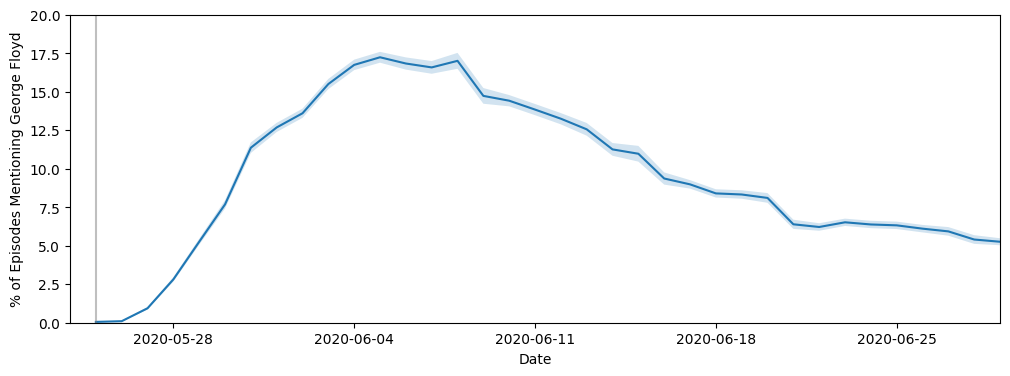

In [123]:
#we need to add the confidence bands
fig, ax = plt.subplots(figsize=(12, 4), sharex=True)
ax.fill_between(rollingDf["date"], rollingDf["CI_left"], rollingDf["CI_right"], alpha=.2) 

#plot the actual lines 
sns.lineplot(rollingDf, x="date", y="mean" )


ax.axvline(pd.to_datetime("2020-05-25"), color="grey", alpha=.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_xlabel("Date")
ax.set_ylabel("% of Episodes Mentioning George Floyd")
ax.set_xlim(pd.Timestamp("2020-05-24"), pd.Timestamp("2020-06-29"))
ax.set_ylim(0, 20)

In [ ]:
#ok, now get this for each category? 
cats = ["news", "business", "society", "sports", "religion", "education"]

In [125]:
#now get that time series baybeee 
outputDfs = []

for date in pd.date_range(minDate, maxDate): 
    for cat in cats: 
        #get the three days before if they exist 
        currDf = afterFloyd.loc[date - pd.Timedelta(days=1) : date + pd.Timedelta(days=1), ["hasFloyd", "category1"]]
        currDf = currDf[currDf["category1"] == cat].drop(columns="category1") 
        means = currDf.apply("mean")
        stdevs = currDf.apply("std")
        n = len(currDf)

        #here are the actual t-distribution confidence intervals 
        confInt = getConf(means, n)
        currOutput = pd.DataFrame(pd.concat([means, confInt])).T
        #CIs = currDf.apply(lambda x: DescrStatsW(x).tconfint_mean(), axis=0)
        #currOutput = pd.concat([means, CIs.T], axis=1)
        currOutput.columns = ["mean", "CI_left", "CI_right"]
        currOutput["date"] = date
        currOutput["Category"] = cat
        outputDfs.append(currOutput)
rollingDf = pd.concat(outputDfs, axis=0).reset_index().rename(columns={"index":"topic"})

In [126]:
rollingDf["mean"] = rollingDf["mean"] * 100
rollingDf["CI_left"] = rollingDf["CI_left"] * 100
rollingDf["CI_right"] = rollingDf["CI_right"] * 100

In [128]:
rollingDf.to_json("/shared/3/projects/benlitterer/podcastData/figureData/floydFigures/gfPropCategories.jsonl", orient="records", lines=True)

(18407.0, 18442.0)

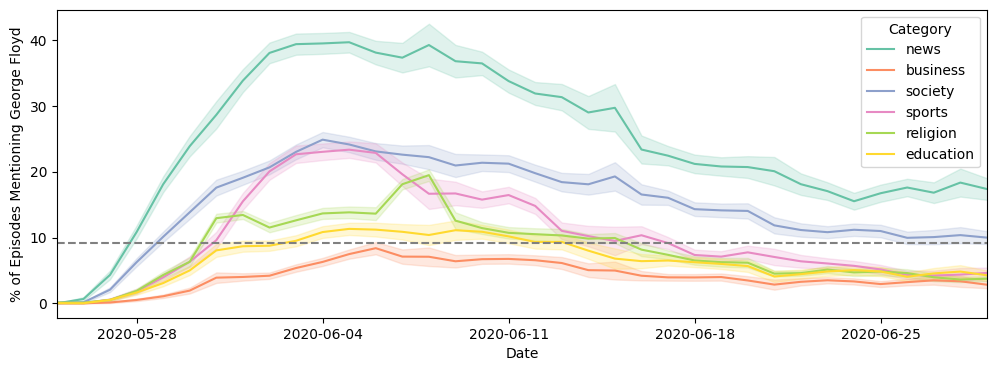

In [127]:
palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']
fig, ax = plt.subplots(figsize=(12, 4), sharex=True)


#we need to add the confidence bands
for i, topic in enumerate(cats): 
    currData = rollingDf[rollingDf["Category"] == topic]
    ax.fill_between(currData["date"], currData["CI_left"], currData["CI_right"], color=palette[i], alpha=.2) 

#plot the actual lines 
sns.lineplot(rollingDf, x="date", y="mean", hue="Category", hue_order=cats, palette=palette)


#ax.axvline(pd.to_datetime("2020-05-25"), color="grey", alpha=.5)
ax.axhline(9.2, color="grey", linestyle="--")


#fig.legend(legend_elements, titleList, loc='lower center', ncol=3, fontsize='large', bbox_to_anchor=(0.5, -0.1))

ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_xlabel("Date")
ax.set_ylabel("% of Episodes Mentioning George Floyd")
ax.set_xlim(pd.Timestamp("2020-05-25"), pd.Timestamp("2020-06-29"))

#fig.suptitle("Temporal Evolution of Topics Relating to George Floyd and Racial Justice")

In [ ]:
#de-mean 
#first find the averages within categories 
catMeans = afterFloyd[["category1", "hasFloyd"]].groupby("category1").agg("mean").loc[cats]

In [ ]:
means - catMeans.loc["news"]

hasFloyd   -0.199342
dtype: float64

In [ ]:
catMeans.loc["news"]

hasFloyd    0.242909
Name: news, dtype: float64

In [ ]:
CIs - catMeans.loc[cat]

,hasFloyd
0,-0.028672
1,-0.010540


In [ ]:

#now get that time series baybeee (but de-mean)
outputDfs = []

for date in pd.date_range(minDate, maxDate): 
    for cat in cats: 
        #get the three days before if they exist 
        currDf = afterFloyd.loc[date - pd.Timedelta(days=1) : date + pd.Timedelta(days=1), ["hasFloyd", "category1"]]
        currDf = currDf[currDf["category1"] == cat].drop(columns="category1") 
        means = currDf.apply("mean") - catMeans.loc[cat]
        stdevs = currDf.apply("std")
        n = len(currDf)

        #here are the actual t-distribution confidence intervals 
        CIs = currDf.apply(lambda x: DescrStatsW(x).tconfint_mean(), axis=0)
        CIs = CIs - catMeans.loc[cat]
        currOutput = pd.concat([means, CIs.T], axis=1)
        currOutput.columns = ["mean", "CI_left", "CI_right"]
        currOutput["date"] = date
        currOutput["Category"] = cat
        outputDfs.append(currOutput)
rollingDf = pd.concat(outputDfs, axis=0).reset_index().rename(columns={"index":"topic"})

In [ ]:
rollingDf["mean"] = rollingDf["mean"] * 100
rollingDf["CI_left"] = rollingDf["CI_left"] * 100
rollingDf["CI_right"] = rollingDf["CI_right"] * 100

(18407.0, 18442.0)

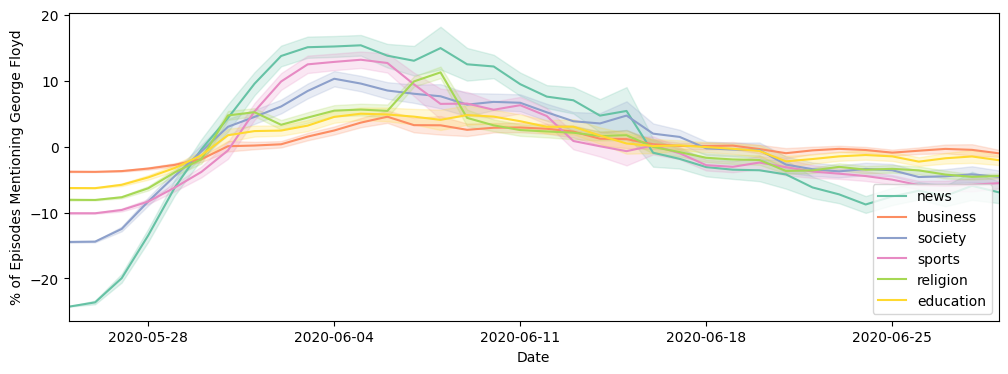

In [ ]:
palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']
fig, ax = plt.subplots(figsize=(12, 4), sharex=True)


#we need to add the confidence bands
for i, topic in enumerate(cats): 
    currData = rollingDf[rollingDf["Category"] == topic]
    ax.fill_between(currData["date"], currData["CI_left"], currData["CI_right"], color=palette[i], alpha=.2) 

#plot the actual lines 
sns.lineplot(rollingDf, x="date", y="mean", hue="Category", hue_order=cats, palette=palette)


#ax.axvline(pd.to_datetime("2020-05-25"), color="grey", alpha=.5)
#ax.axhline(9.2, color="grey", linestyle="--")


#fig.legend(legend_elements, titleList, loc='lower center', ncol=3, fontsize='large', bbox_to_anchor=(0.5, -0.1))
ax.legend(loc="lower right")
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_xlabel("Date")
ax.set_ylabel("% of Episodes Mentioning George Floyd")
ax.set_xlim(pd.Timestamp("2020-05-25"), pd.Timestamp("2020-06-29"))

#fig.suptitle("Temporal Evolution of Topics Relating to George Floyd and Racial Justice")

In [ ]:
afterFloyd["hasBLM"] = afterFloyd["transcript"].apply(lambda x: "black lives matter" in " ".join(x.split()).lower())

In [ ]:

hasBLM = afterFloyd[afterFloyd["hasBLM"] == True]
print(f'number of podcasts mentioning BLM after BLM: {len(hasBLM["rssUrl"].unique())}')
print(f'number of episodes mentioning BLM after BLM:  {len(hasBLM["potentialOutPath"].unique())}')

print(f'percentage of podcasts mentioning BLM after BLM: {len(hasBLM["rssUrl"].unique())/len(afterFloyd["rssUrl"].unique())}')
print(f'percentage of episodes mentioning BLM after BLM: {len(hasBLM["potentialOutPath"].unique())/len(afterFloyd["potentialOutPath"].unique())}')

number of podcasts mentioning BLM after BLM: 35298
number of episodes mentioning BLM after BLM:  54569
percentage of podcasts mentioning BLM after BLM: 0.19726495917557577
percentage of episodes mentioning BLM after BLM: 0.0846201560004342


In [ ]:
#minDate = min(hasFloyd["cleanDatesLoc"])
#maxDate = max(afterFloyd["cleanDatesLoc"])
minDate = "2020-05-25"
maxDate = "2020-06-30"

#now get that time series baybeee 
outputDfs = []

for date in pd.date_range(minDate, maxDate): 
    #get the three days before if they exist 
    currDf = afterFloyd.loc[date - pd.Timedelta(days=1) : date + pd.Timedelta(days=1), ["hasBLM"]]
    means = currDf.apply("mean")
    stdevs = currDf.apply("std")
    n = len(currDf)
    
    #here are the actual t-distribution confidence intervals 
    CIs = currDf.apply(lambda x: DescrStatsW(x).tconfint_mean(), axis=0)
    currOutput = pd.concat([means, CIs.T], axis=1)
    currOutput.columns = ["mean", "CI_left", "CI_right"]
    currOutput["date"] = date
    outputDfs.append(currOutput)

rollingDf = pd.concat(outputDfs, axis=0).reset_index().rename(columns={"index":"topic"})

In [ ]:
rollingDf["mean"] = rollingDf["mean"] * 100
rollingDf["CI_left"] = rollingDf["CI_left"] * 100
rollingDf["CI_right"] = rollingDf["CI_right"] * 100

In [ ]:

rollingDf.to_json("/shared/3/projects/benlitterer/podcastData/figureData/floydFigures/BLMProp.jsonl", orient="records", lines=True)


(0.0, 20.0)

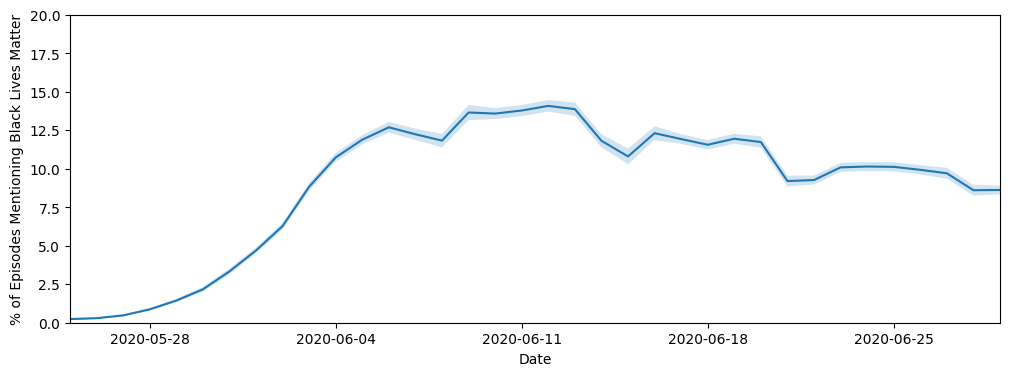

In [ ]:

#we need to add the confidence bands
fig, ax = plt.subplots(figsize=(12, 4), sharex=True)
ax.fill_between(rollingDf["date"], rollingDf["CI_left"], rollingDf["CI_right"], alpha=.2) 

#plot the actual lines 
sns.lineplot(rollingDf, x="date", y="mean" )


#ax.axvline(pd.to_datetime("2020-05-25"), color="grey", alpha=.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_xlabel("Date")
ax.set_ylabel("% of Episodes Mentioning Black Lives Matter")
ax.set_xlim(pd.Timestamp("2020-05-25"), pd.Timestamp("2020-06-29"))
ax.set_ylim(0, 20)

(18407.0, 18442.0)

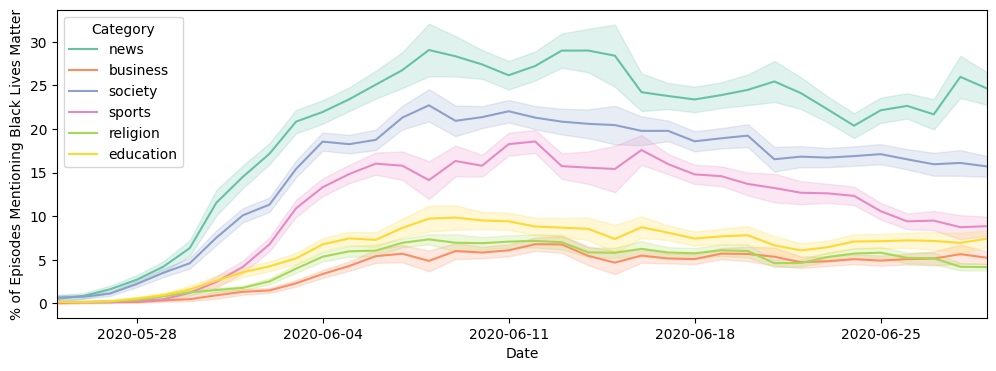

In [ ]:

#now get that time series baybeee 
outputDfs = []

for date in pd.date_range(minDate, maxDate): 
    for cat in cats: 
        #get the three days before if they exist 
        currDf = afterFloyd.loc[date - pd.Timedelta(days=1) : date + pd.Timedelta(days=1), ["hasBLM", "category1"]]
        currDf = currDf[currDf["category1"] == cat].drop(columns="category1") 
        means = currDf.apply("mean")
        stdevs = currDf.apply("std")
        n = len(currDf)

        #here are the actual t-distribution confidence intervals 
        CIs = currDf.apply(lambda x: DescrStatsW(x).tconfint_mean(), axis=0)
        currOutput = pd.concat([means, CIs.T], axis=1)
        currOutput.columns = ["mean", "CI_left", "CI_right"]
        currOutput["date"] = date
        currOutput["Category"] = cat
        outputDfs.append(currOutput)
rollingDf = pd.concat(outputDfs, axis=0).reset_index().rename(columns={"index":"topic"})

rollingDf["mean"] = rollingDf["mean"] * 100
rollingDf["CI_left"] = rollingDf["CI_left"] * 100
rollingDf["CI_right"] = rollingDf["CI_right"] * 100

rollingDf.to_json("/shared/3/projects/benlitterer/podcastData/figureData/floydFigures/BLMPropCategories.jsonl", orient="records", lines=True)

palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']
fig, ax = plt.subplots(figsize=(12, 4), sharex=True)


#we need to add the confidence bands
for i, topic in enumerate(cats): 
    currData = rollingDf[rollingDf["Category"] == topic]
    ax.fill_between(currData["date"], currData["CI_left"], currData["CI_right"], color=palette[i], alpha=.2) 

#plot the actual lines 
sns.lineplot(rollingDf, x="date", y="mean", hue="Category", hue_order=cats, palette=palette)

#ax.axvline(pd.to_datetime("2020-05-25"), color="grey", alpha=.5)
#ax.axhline(9.2, color="grey", linestyle="--")


#fig.legend(legend_elements, titleList, loc='lower center', ncol=3, fontsize='large', bbox_to_anchor=(0.5, -0.1))

ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_xlabel("Date")
ax.set_ylabel("% of Episodes Mentioning Black Lives Matter")
ax.set_xlim(pd.Timestamp("2020-05-25"), pd.Timestamp("2020-06-29"))

#fig.suptitle("Temporal Evolution of Topics Relating to George Floyd and Racial Justice")